In [1]:
from __future__ import print_function
%matplotlib inline

import datetime

import os

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split

import re
import string

PROJ_ROOT = os.path.join(os.pardir, os.pardir)

In [2]:
path = '/Users/teresiahkahura/Desktop/ds/SB-Capstone2/data/processed/reviews5.pkl'
df = pd.read_pickle(path)

assert df.shape == (3268, 2)

# Preprocessing

In [3]:
x = df["text"]
y = df["label"].values

In [4]:
tokenizer = Tokenizer(lower=True, filters='\d*!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', split = ' ')
tokenizer.fit_on_texts(x)

In [5]:
def get_sequence_of_tokens(corpus):
    
    
    total_words = len(tokenizer.word_index) + 1
    
     
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        input_sequences.append(token_list)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(x)

In [6]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len,))
   
    predictors = input_sequences[:,:-1]
    return predictors, max_sequence_len

predictors, max_sequence_len = generate_padded_sequences(inp_sequences)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(predictors, y, test_size=0.45, random_state=42)

# Setting up RNN


In [17]:
def build_model():
  opt = Adam(lr=0.001)
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(total_words, 128))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(128)))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  
  return model

rnn_model = build_model()

In [18]:
!rm -r /tmp/logs/

In [19]:
logdir = os.path.join("/tmp/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='/tmp/sentiment_analysis_rnn.hdf5', 
                                                  verbose = 1, 
                                                  save_best_only= True)

In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
history_rnn = rnn_model.fit(x_train, y_train, epochs = 10, validation_split=0.1, 
                              callbacks = [tb_callback, checkpoint])

Epoch 1/10
51/51 [==============================] - ETA: 0s - loss: 0.7062 - accuracy: 0.5139
Epoch 00001: val_loss improved from inf to 0.70234, saving model to /tmp/sentiment_analysis_rnn.hdf5
51/51 [==============================] - 6s 119ms/step - loss: 0.7062 - accuracy: 0.5139 - val_loss: 0.7023 - val_accuracy: 0.4611
Epoch 2/10
51/51 [==============================] - ETA: 0s - loss: 0.6829 - accuracy: 0.5720
Epoch 00002: val_loss improved from 0.70234 to 0.68678, saving model to /tmp/sentiment_analysis_rnn.hdf5
51/51 [==============================] - 6s 108ms/step - loss: 0.6829 - accuracy: 0.5720 - val_loss: 0.6868 - val_accuracy: 0.5833
Epoch 3/10
51/51 [==============================] - ETA: 0s - loss: 0.5560 - accuracy: 0.7229
Epoch 00003: val_loss improved from 0.68678 to 0.59031, saving model to /tmp/sentiment_analysis_rnn.hdf5
51/51 [==============================] - 6s 108ms/step - loss: 0.5560 - accuracy: 0.7229 - val_loss: 0.5903 - val_accuracy: 0.6778
Epoch 4/10
51/

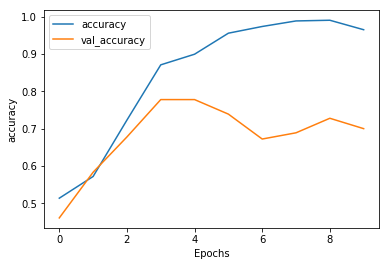

In [21]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+ metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+ metric])
  plt.show()

plot_graphs(history_rnn, 'accuracy')

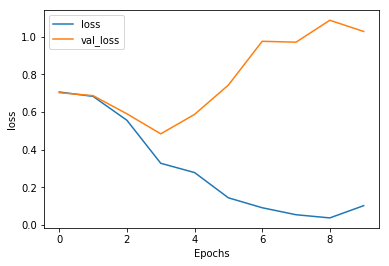

In [22]:
plot_graphs(history_rnn, 'loss')

In [23]:
results = rnn_model.evaluate(x_test, y_test)
print(results)

46/46 [==============================] - 1s 21ms/step - loss: 0.8889 - accuracy: 0.7376
[0.8888649940490723, 0.7375934720039368]
